In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lung-cancer/survey lung cancer.csv


The effectiveness of cancer prediction system helps the people to know their cancer risk with low cost and it also helps the people to take the appropriate decision based on their cancer risk status. The data is collected from the website online lung cancer prediction system.

Total no. of attributes:16

No .of instances:284

**Attribute information:**

Gender: M(male), F(female)

Age: Age of the patient

Smoking: YES=2 , NO=1.

Yellow fingers: YES=2 , NO=1.

Anxiety: YES=2 , NO=1.

Peer_pressure: YES=2 , NO=1.

Chronic Disease: YES=2 , NO=1.

Fatigue: YES=2 , NO=1.

Allergy: YES=2 , NO=1.

Wheezing: YES=2 , NO=1.

Alcohol: YES=2 , NO=1.

Coughing: YES=2 , NO=1.

Shortness of Breath: YES=2 , NO=1.

Swallowing Difficulty: YES=2 , NO=1.

Chest pain: YES=2 , NO=1.

Lung Cancer: YES , NO.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/kaggle/input/lung-cancer/survey lung cancer.csv')
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [4]:
data.columns

Index(['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER'],
      dtype='object')

In [5]:
target = 'LUNG_CANCER'

In [6]:
for col in data.columns:
  print(f'unique({col}) = {len(data[col].unique())}')

unique(GENDER) = 2
unique(AGE) = 39
unique(SMOKING) = 2
unique(YELLOW_FINGERS) = 2
unique(ANXIETY) = 2
unique(PEER_PRESSURE) = 2
unique(CHRONIC DISEASE) = 2
unique(FATIGUE ) = 2
unique(ALLERGY ) = 2
unique(WHEEZING) = 2
unique(ALCOHOL CONSUMING) = 2
unique(COUGHING) = 2
unique(SHORTNESS OF BREATH) = 2
unique(SWALLOWING DIFFICULTY) = 2
unique(CHEST PAIN) = 2
unique(LUNG_CANCER) = 2


In [7]:
data.AGE.unique()

array([69, 74, 59, 63, 75, 52, 51, 68, 53, 61, 72, 60, 58, 48, 57, 44, 64,
       21, 65, 55, 62, 56, 67, 77, 70, 54, 49, 73, 47, 71, 66, 76, 78, 81,
       79, 38, 39, 87, 46])

In [8]:
def groupAge(AGE):
    if AGE < 10:
        return 0
    elif AGE < 20:
        return 1
    elif AGE < 30:
        return 2
    elif AGE < 40:
        return 3
    elif AGE < 50:
        return 4
    elif AGE < 60:
        return 5
    elif AGE < 70:
        return 6
    elif AGE < 80:
        return 7
    else:
        return 8

In [9]:
data.isna().sum().sum()

0

In [10]:
data['LUNG_CANCER'].value_counts()

LUNG_CANCER
YES    270
NO      39
Name: count, dtype: int64

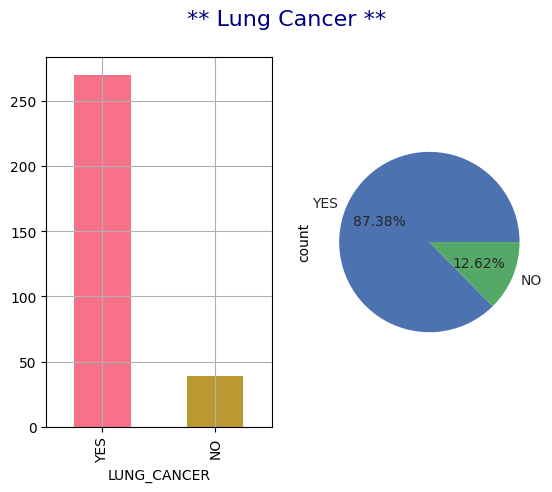

In [11]:
fig, ax = plt.subplots(1, 2) 
fig.suptitle('** ' + 'Lung Cancer' + ' **', fontsize=16, color='navy') 
plt.style.use('seaborn')
plt.subplot(1,2,1)
data['LUNG_CANCER'].value_counts().plot(kind='bar',color=sns.color_palette("husl"))
plt.subplot(1,2,2)
data['LUNG_CANCER'].value_counts().plot(kind='pie',autopct="%.2f%%")
plt.show()

In [12]:
def visualizeData(data: pd.DataFrame, visualizableFields = []):
  n = len(visualizableFields)
  n = n // 2 + (n % 2 != 0)

  plt.figure(figsize = (10, 20))

  for idx, value in enumerate(visualizableFields):
    plt.subplot(n, 2, idx+1)
    sns.countplot(x=value, hue=target, data=data, palette="husl")
    plt.title(f"{value} Distribution")
    plt.tight_layout()

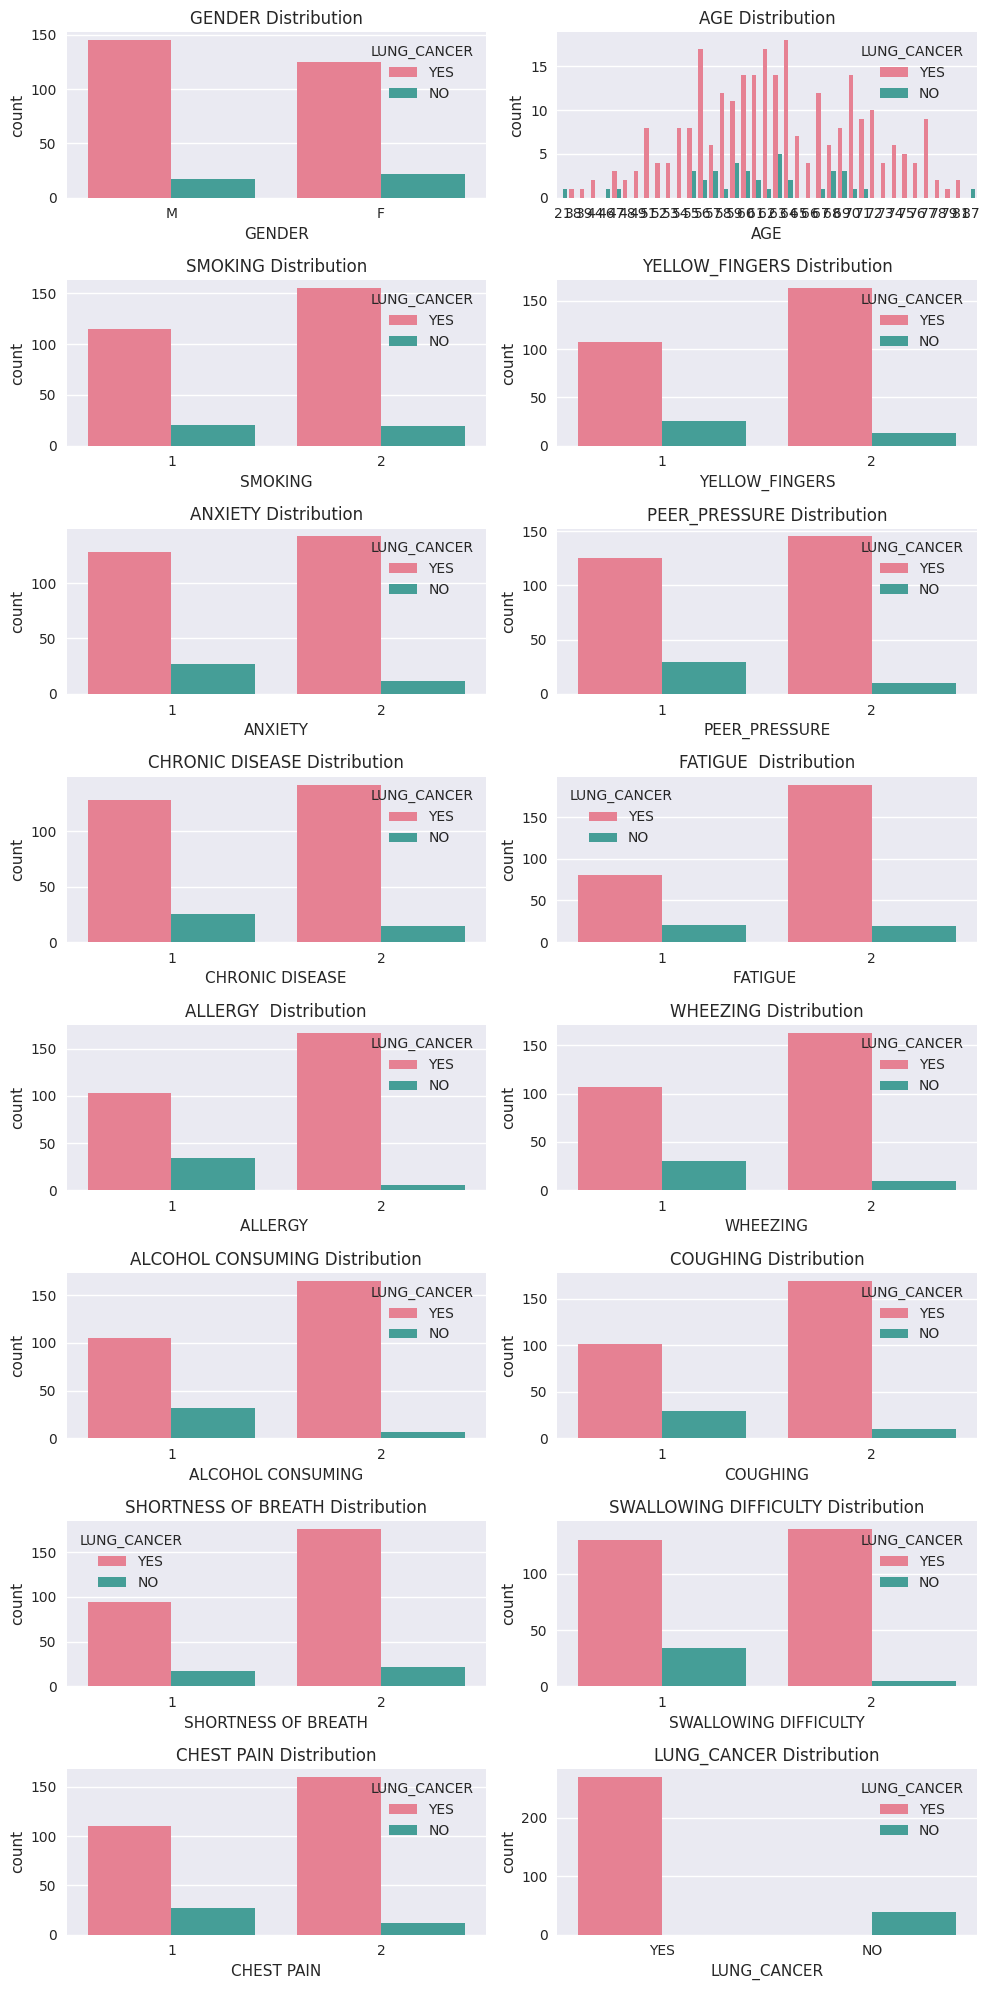

In [13]:
visualizeData(data, visualizableFields = data.columns)

In [15]:
def preprocessData(data: pd.DataFrame):
  data['age_group'] = data['AGE'].apply(groupAge)

  # removing unnecessary fields
  data.drop(columns = ['AGE'], inplace = True)

  return data

In [16]:
def encodingCategorialData(data: pd.DataFrame, isPred: bool = False):
   # label encoding categorical fields
    cols2labelEncode = ['GENDER', 'LUNG_CANCER']

    le = LabelEncoder()

    for col in cols2labelEncode:
        data[col] = le.fit_transform(data[col])

    return data

In [17]:
def zscoringData(data: pd.DataFrame):
  # zscoring all the fields
  cols2zscore = data.keys()
  cols2zscore = cols2zscore.drop(target)
  data[cols2zscore] = data[cols2zscore].astype(float).apply(stats.zscore)

  return data

In [18]:
def getFeaturesAndLabels(data: pd.DataFrame):
  fields = data.keys().drop(target)

  features = data[fields].values.astype(float)
  labels = data[target].values.astype(int)

  # conversion to tensors
  featuresT = torch.Tensor(features)
  labelsT = torch.Tensor(labels)[:, None]

  return featuresT, labelsT

In [19]:
data = preprocessData(data)
data.head()

,GENDER,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,age_group
0,M,1,2,2,1,1,2,1,2,2,2,2,2,2,YES,6
1,M,2,1,1,1,2,2,2,1,1,1,2,2,2,YES,7
2,F,1,1,1,2,1,2,1,2,1,2,2,1,2,NO,5
3,M,2,2,2,1,1,1,1,1,2,1,1,2,2,NO,6
4,F,1,2,1,1,1,1,1,2,1,2,2,1,1,NO,6


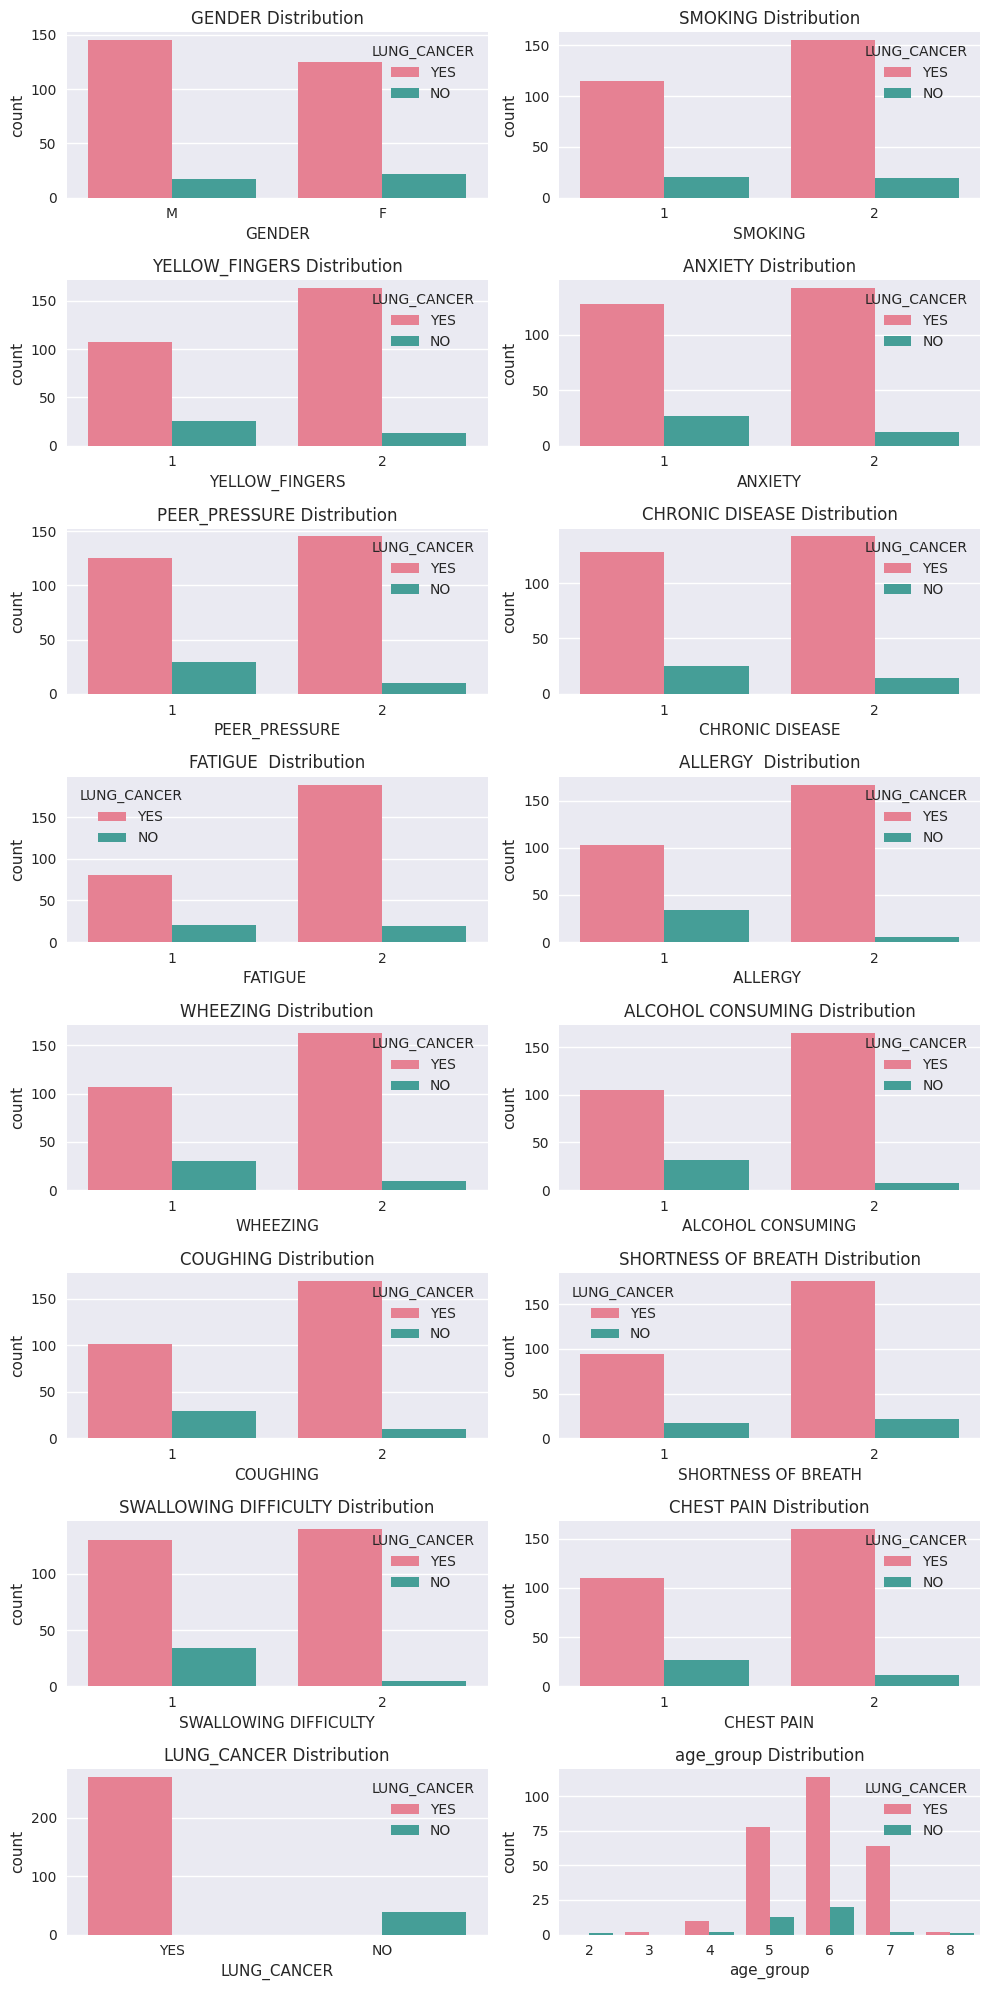

In [20]:
visualizeData(data, visualizableFields = data.columns)

In [21]:
data = encodingCategorialData(data)
data.head()

,GENDER,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,age_group
0,1,1,2,2,1,1,2,1,2,2,2,2,2,2,1,6
1,1,2,1,1,1,2,2,2,1,1,1,2,2,2,1,7
2,0,1,1,1,2,1,2,1,2,1,2,2,1,2,0,5
3,1,2,2,2,1,1,1,1,1,2,1,1,2,2,0,6
4,0,1,2,1,1,1,1,1,2,1,2,2,1,1,0,6


In [22]:
data = zscoringData(data)
data.head()

,GENDER,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,age_group
0,0.952579,-1.135292,0.869300,1.003241,-1.003241,-1.009756,0.696833,-1.120480,0.892475,0.892475,0.852207,0.748736,1.063501,0.892475,1,0.193852
1,0.952579,0.880830,-1.150351,-0.996769,-1.003241,0.990338,0.696833,0.892475,-1.120480,-1.120480,-1.173424,0.748736,1.063501,0.892475,1,1.324046
2,-1.049781,-1.135292,-1.150351,-0.996769,0.996769,-1.009756,0.696833,-1.120480,0.892475,-1.120480,0.852207,0.748736,-0.940291,0.892475,0,-0.936342
3,0.952579,0.880830,0.869300,1.003241,-1.003241,-1.009756,-1.435063,-1.120480,-1.120480,0.892475,-1.173424,-1.335584,1.063501,0.892475,0,0.193852
4,-1.049781,-1.135292,0.869300,-0.996769,-1.003241,-1.009756,-1.435063,-1.120480,0.892475,-1.120480,0.852207,0.748736,-0.940291,-1.120480,0,0.193852


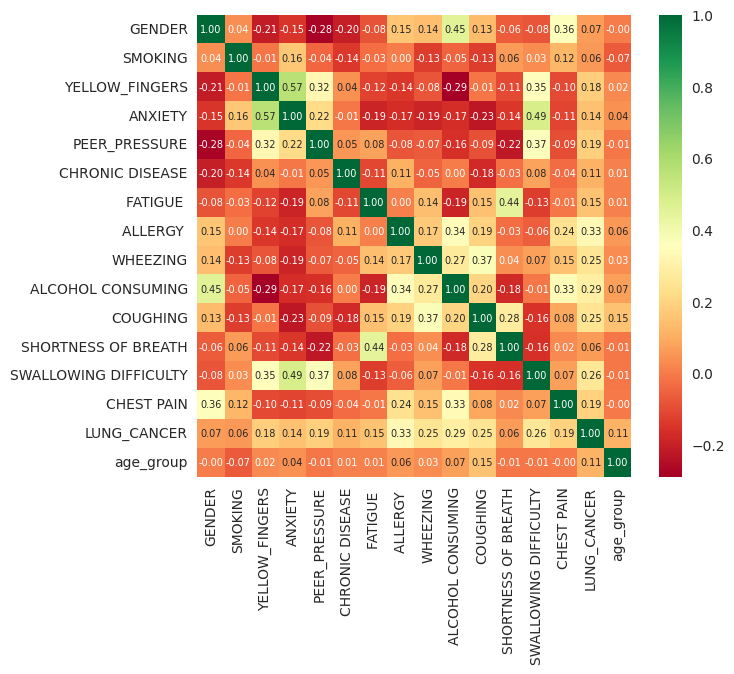

In [23]:
# Heatmap

df_corr = data.corr()
f, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='RdYlGn',annot_kws={'size': 7}, ax=ax)
plt.show()

In [27]:
featuresT, labelsT = getFeaturesAndLabels(data)
train_data, test_data, train_labels, test_labels = train_test_split(featuresT, labelsT, shuffle = True, test_size = 0.2)
print(f'Train data: {len(train_data)} | Train labels: {len(train_labels)}')
print(f'Test data: {len(test_data)} | Test labels: {len(test_labels)}')

Train data: 247 | Train labels: 247
Test data: 62 | Test labels: 62


In [28]:
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batchsize = 32

train_dataloader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])

### <b><span style='color:#DEB078'>6.1 |</span><span style='color:#F58730'> Make Network</span></b>  

In [29]:
def makeTheNet():

  class ANNnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(featuresT.shape[1], 256)

      self.fc1 = nn.Linear(256, 256)
      self.bn1 = nn.BatchNorm1d(256)

      self.fc2 = nn.Linear(256, 256)
      self.bn2 = nn.BatchNorm1d(256)

      self.fc3 = nn.Linear(256, 256)
      self.bn3 = nn.BatchNorm1d(256)

      self.fc4 = nn.Linear(256, 256)
      self.bn4 = nn.BatchNorm1d(256)

      self.fc5 = nn.Linear(256, 256)
      self.bn5 = nn.BatchNorm1d(256)

      self.output = nn.Linear(256, 1)

    def forward(self, x):
      x = F.relu( self.input(x) )
      x = F.dropout(x, .5)

      x = self.fc1(x)
      x = self.bn1(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc2(x)
      x = self.bn2(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc3(x)
      x = self.bn3(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc4(x)
      x = self.bn4(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc5(x)
      x = self.bn5(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      return self.output(x)

  net = ANNnet()

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.Adam(net.parameters(), lr = .0001)

  return net, lossfun, optimizer

In [30]:
net, lossfun, optimizer = makeTheNet()

In [31]:
X, y = next(iter(train_dataloader))
yHat = net(X)
lossfun(yHat, y)

tensor(0.5832, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

### <b><span style='color:#DEB078'>6.2 |</span><span style='color:#F58730'> Train Network</span></b>

In [32]:
def functionToTrainNet():
  epochs = 200

  net, lossfun, optimizer = makeTheNet()

  trainAcc = []
  trainLoss = []
  testAcc = []
  testLoss = []
    
  yTrue = []
  yPred = []

  for epochi in tqdm(range(epochs)):

    net.train()

    batchAcc = []
    batchLoss = []

    for X, y in train_dataloader:
      yHat = net(X)
      loss = lossfun(yHat, y)

      batchLoss.append(loss.item())
      batchAcc.append(torch.mean(((yHat > .0) == y).float()) * 100)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))

    net.eval()
    with torch.no_grad():
      X, y = next(iter(test_dataloader))
      yHat = net(X)
      loss = lossfun(yHat, y)
    
      yPred = (yHat > .0)
      yTrue = y  

      testLoss.append(loss.item())
      testAcc.append(torch.mean((yPred == y).float()) * 100)

  return trainAcc, testAcc, trainLoss, testLoss, net, yTrue, yPred

In [33]:
trainAcc, testAcc, trainLoss, testLoss, net, yTrue, yPred = functionToTrainNet()

100%|██████████| 200/200 [00:09<00:00, 21.96it/s]


### <b><span style='color:#DEB078'>6.3 |</span><span style='color:#F58730'> Plot results for Train and Test</span></b>

In [37]:
import torch

# Save the trained model
torch.save(net.state_dict(), "/kaggle/working/trained_model.pth")


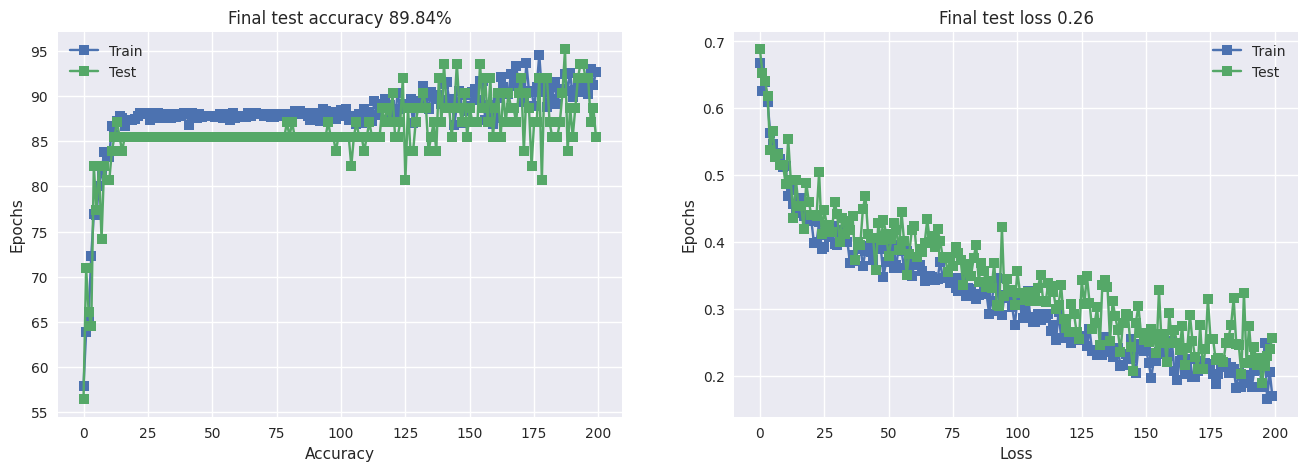

In [34]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainAcc, 's-', label = 'Train')
ax[0].plot(testAcc, 's-', label = 'Test')
ax[0].set_title(f'Final test accuracy {np.mean(testAcc[-10:]):.2f}%')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epochs')
ax[0].legend()

ax[1].plot(trainLoss, 's-', label = 'Train')
ax[1].plot(testLoss, 's-', label = 'Test')
ax[1].set_title(f'Final test loss {testLoss[-1]:.2f}')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epochs')
ax[1].legend()

plt.show()

### <b><span style='color:#DEB078'>6.4 |</span><span style='color:#F58730'> Confusion Matrix</span></b>

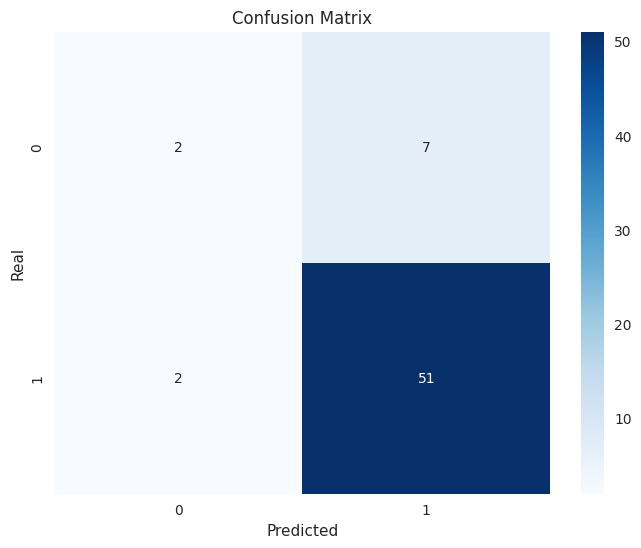

In [35]:
cm = confusion_matrix(yTrue, yPred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

### <b><span style='color:#DEB078'>6.5 |</span><span style='color:#F58730'> Precision, Recall and F1-Score</span></b>

In [36]:
precision = precision_score(yTrue, yPred)
recall = recall_score(yTrue, yPred)
f1Score = f1_score(yTrue, yPred)

print(f'Precision: {precision}')
print(f'Recall:    {recall}')
print(f'F1 Score:  {f1Score}')

Precision: 0.8793103448275862
Recall:    0.9622641509433962
F1 Score:  0.9189189189189189
